Importing libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  []


Loading dataset

In [3]:
dataset = pd.read_csv('grouped_cystein5_feature_ex.csv')

In [4]:
# creating Tokenizer to split single peptides from each other
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True) 
tokenizer.fit_on_texts(dataset['sequence'])
# building sequences of tokenized series of peptides
sequence_data = tokenizer.texts_to_sequences(dataset['sequence'])  
sequence_data

[[3, 1, 15, 6, 2, 19, 18, 9],
 [7, 20, 2, 4, 19, 2, 7],
 [1, 14, 2, 11, 2, 9, 7],
 [1, 14, 2, 11, 2, 9, 7],
 [8, 6, 5, 2, 11, 6, 16, 2, 6, 1, 7],
 [7, 20, 2, 4, 19, 2, 7],
 [6, 10, 14, 11, 14, 14, 13, 10, 11, 14, 7],
 [2, 1, 14, 14, 13, 13, 10, 6, 14, 8, 7],
 [17, 14, 5, 1, 14, 2, 11, 10, 8, 11, 7],
 [7, 20, 2, 4, 19, 2, 7],
 [7, 20, 2, 4, 19, 2, 7],
 [8, 2, 2, 13, 14, 14, 10, 11, 14, 10, 7],
 [8, 2, 2, 13, 14, 14, 10, 11, 14, 10, 7],
 [1, 9, 3, 3, 13, 3, 6, 7],
 [8, 2, 2, 13, 14, 14, 10, 11, 14, 10, 7],
 [2, 1, 14, 14, 13, 13, 10, 6, 14, 8, 7],
 [7, 20, 2, 4, 19, 2, 7],
 [8, 11, 8, 12, 1, 3, 18, 7],
 [8, 2, 2, 13, 14, 14, 10, 11, 14, 10, 7],
 [8, 11, 8, 12, 1, 3, 18, 7],
 [8, 2, 2, 13, 14, 14, 10, 11, 14, 10, 7],
 [16, 6, 14, 2, 2, 3, 10, 13, 14, 11, 7],
 [7, 20, 2, 4, 19, 2, 7],
 [14, 14, 1, 11, 6, 11, 2, 13, 14, 8, 7],
 [14, 14, 1, 11, 6, 11, 2, 13, 14, 8, 7],
 [1, 14, 2, 11, 2, 9, 7],
 [1, 14, 2, 11, 2, 9, 7],
 [8, 2, 2, 13, 14, 14, 10, 11, 14, 10, 7],
 [8, 2, 2, 13, 14, 14, 10, 11

Padding sequences to receive series with the same length

In [5]:
sequence_data = tf.keras.preprocessing.sequence.pad_sequences(sequence_data, padding='post')
sequence_data

array([[ 3,  1, 15, ...,  0,  0,  0],
       [ 7, 20,  2, ...,  0,  0,  0],
       [ 1, 14,  2, ...,  0,  0,  0],
       ...,
       [12,  1,  3, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  0,  0,  0]])

Scaling numerical data (without retention time and sequences) in order to normalize data for better result (according to Gaussian distribution with mean 0 and standard deviation 1)

In [6]:
scaler = StandardScaler()
numerical_data = dataset[['is_modified', 'hydrophobicity', 'aromaticity', 'cystein_count', 'molecular_weight', 'instability_index', 'isoelectric_point']].astype(float)
scaled_numerical_data = scaler.fit_transform(numerical_data)

Transforming column of retention time from pandas DataFrame to numpy array

In [7]:
y = dataset['retention_time'].values

Reshaping sequence data to get shape of (batch_size, sequence_length, 1) which is requirement of Tensorflow.
Spliting data into training and testing set of data

In [8]:
sequence_data = sequence_data.reshape(sequence_data.shape[0], sequence_data.shape[1], 1)

X_train_seq, X_test_seq, X_train_num, X_test_num, y_train, y_test = train_test_split(
    sequence_data, scaled_numerical_data, y, test_size=0.2)

Building model which contains two NN. The first one is LSTM for processing sequences and the second one performs classical feed-forward pass with convolutional layer with 16 filters

In [10]:
# CNN - LSTM model 
sequence_input = tf.keras.layers.Input(shape=(sequence_data.shape[1], 1))
conv = tf.keras.layers.Conv1D(filters=16, activation='relu', kernel_size=3)(sequence_input)
lstm = tf.keras.layers.LSTM(64)(conv)
lstm_output = tf.keras.layers.Dense(1)(lstm)

numerical_input = tf.keras.layers.Input(shape=(scaled_numerical_data.shape[1],))

concat = tf.keras.layers.Concatenate()([lstm_output, numerical_input])

dense1 = tf.keras.layers.Dense(128, activation='relu')(concat)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
output = tf.keras.layers.Dense(1)(dense2)

# LSTM - CNN model 
sequence_input = tf.keras.layers.Input(shape=(sequence_data.shape[1], 1))
lstm = tf.keras.layers.LSTM(64)(sequence_input)
lstm_output = tf.keras.layers.Dense(1)(lstm)

numerical_input = tf.keras.layers.Input(shape=(scaled_numerical_data.shape[1],))

concat = tf.keras.layers.Concatenate()([lstm_output, numerical_input])

reshaped_concat = tf.keras.layers.Reshape((concat.shape[1], 1))(concat)
conv = tf.keras.layers.Conv1D(filters=16, activation='relu', kernel_size=3)(reshaped_concat)

flatten = tf.keras.layers.Flatten()(conv)
dense1 = tf.keras.layers.Dense(128, activation='relu')(flatten)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1) 
output = tf.keras.layers.Dense(1)(dense2)

Compiling model (defining what type of loss function and optimizer is going to be), plus printing summarization of model structure

In [11]:
optimizer = tf.keras.optimizers.Adam()
cost_function = tf.keras.losses.MeanSquaredError()
model = tf.keras.models.Model(inputs=[sequence_input, numerical_input], outputs=output)
model.compile(optimizer=optimizer, loss=cost_function)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 58, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 56, 16)    │         64 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     20,736 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8)         │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      1,152 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,338 (118.51 KB)

 Trainable params: 30,338 (118.51 KB)

 Non-trainable params: 0 (0.00 B)

Training and testing our model with optimized number of epochs and appropriate size of the batch

In [14]:
fit = model.fit([X_train_seq, X_train_num], y_train, epochs=50, batch_size=10000, validation_data=([X_test_seq, X_test_num], y_test))

Epoch 1/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 627s 420ms/step - loss: 0.2070 - val_loss: 0.2119
Epoch 2/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 766s 513ms/step - loss: 0.2035 - val_loss: 0.1989
Epoch 3/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 741s 496ms/step - loss: 0.1992 - val_loss: 0.1947
Epoch 4/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 812s 544ms/step - loss: 0.1933 - val_loss: 0.1834
Epoch 5/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 784s 525ms/step - loss: 0.1831 - val_loss: 0.1774
Epoch 6/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 688s 460ms/step - loss: 0.1777 - val_loss: 0.1743
Epoch 7/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 899s 602ms/step - loss: 0.1744 - val_loss: 0.1713
Epoch 8/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 1187s 795ms/step - loss: 0.1724 - val_loss: 0.1744
Epoch 9/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 1341s 899ms/step - loss: 0.1703 - val_loss: 0.1683
Epoch 10/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 1089s 729ms/step - loss: 0.1678 - val_loss: 0.1681
Epoch 11/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 917s 614ms/step - loss: 0.1661 - 

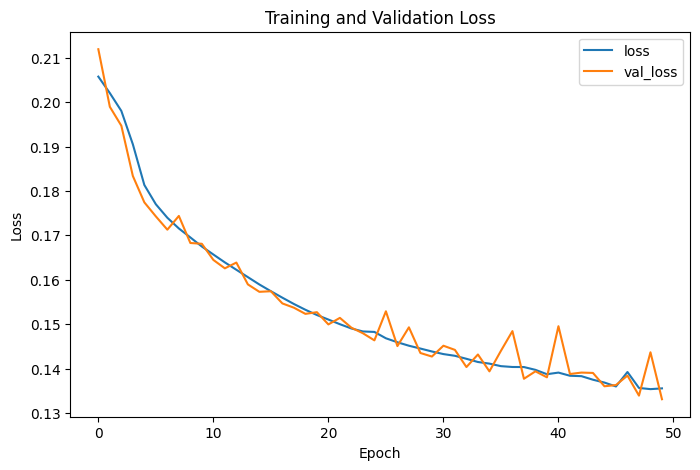

In [15]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt
# Convert fit.history to a DataFrame
history_df = pd.DataFrame(fit.history)

# Plot the training and validation loss
history_df.plot(figsize=(8, 5))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

In [16]:
# Step 1: Generate predictions using the test data
y_pred = model.predict([X_test_seq, X_test_num])  # Make sure the model is trained before this step

# Step 2: Calculate MSE using TensorFlow
mse_value = tf.keras.losses.MeanSquaredError()
mse_result = mse_value(y_test, y_pred).numpy()  # Convert tensor to a scalar value with .numpy()
print(f"Manual MSE: {mse_result}")

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1', 'keras_tensor_5']. Received: the structure of inputs=('*', '*')
  warnings.warn(


116505/116505 ━━━━━━━━━━━━━━━━━━━━ 382s 3ms/step
Manual MSE: 0.13309147953987122


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Combine the sequence and numerical data if your model expects them together
# X_train = np.concatenate([X_train_seq, X_train_num], axis=-1)
# X_val = np.concatenate([X_test_seq, X_test_num], axis=-1)

# Or use them separately if your model has two inputs
X_train = [X_train_seq, X_train_num]
X_val = [X_test_seq, X_test_num]

# Generate predictions
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)

# Calculate metrics for the training set
train_mse = mean_squared_error(y_train, train_predictions)
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

# Calculate metrics for the validation set
val_mse = mean_squared_error(y_test, val_predictions)
val_mae = mean_absolute_error(y_test, val_predictions)
val_r2 = r2_score(y_test, val_predictions)

print("Training Metrics:")
print(f"Mean Squared Error: {train_mse}")
print(f"Mean Absolute Error: {train_mae}")
print(f"R-squared: {train_r2}")

print("\nValidation Metrics:")
print(f"Mean Squared Error: {val_mse}")
print(f"Mean Absolute Error: {val_mae}")
print(f"R-squared: {val_r2}")

466020/466020 ━━━━━━━━━━━━━━━━━━━━ 1735s 4ms/step
116505/116505 ━━━━━━━━━━━━━━━━━━━━ 716s 6ms/step
Training Metrics:
Mean Squared Error: 0.13266304643334137
Mean Absolute Error: 0.23925336114128173
R-squared: 0.869395088643277

Validation Metrics:
Mean Squared Error: 0.13309147918744935
Mean Absolute Error: 0.23953175394301454
R-squared: 0.8688713408136006


In [18]:
import time
start_time = time.time()
# Train your model here
end_time = time.time()
print(f"Epoch Time: {end_time - start_time} seconds")

Epoch Time: 0.0 seconds
